In [1]:
import crispat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import warnings
import time

In [2]:
data_dir = '../../example_data/'

To use the `crispat` assignments with `scanpy`, the following inputs are needed: 
- processed gene expression data: preprocessing of gene expression counts can e.g. be done with scanpy (filtering of cells, normalization, log-transformation, z-scoring etc.)
- cell-gRNA assignments for various methods obtained by crispat: for this we read in the file 'single_assignments_all_methods.csv' that we created in our [guide assignment tutorial](https://github.com/velten-group/crispat/blob/main/tutorials/guide_assignment.ipynb).
- information about the target gene of each gRNA

In [11]:
# Load and preprocess gene expression data of the CRISPR screen
adata = sc.read_csv(data_dir + 'Schraivogel/gene_expression_counts.csv')
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

# Read in assignments for various methods as obtained by crispat
assignments = pd.read_csv(data_dir+'guide_assignments/single_assignments_all_methods.csv')
assignments.loc[assignments['gRNA'].str.contains('non-targeting'), 'gRNA'] = 'non-targeting'

In [12]:
assignments.head()

,cell,gRNA,method
0,TAP1-AAACCTGAGGCGTACA,CROPseq_dCas9_DS_CPQ_+_97657557.23-P1P2,2-Beta
1,TAP1-AAACCTGAGGGCTTGA,CROPseq_dCas9_DS_MYC-D,2-Beta
2,TAP1-AAACCTGAGGGTGTTG,CROPseq_dCas9_DS_PHF20L1_-_133787636-P1P2,2-Beta
3,TAP1-AAACCTGAGGTGCTAG,CROPseq_dCas9_DS_LRRCC1_+_86019483.23-P1P2,2-Beta
4,TAP1-AAACCTGAGTGCGTGA,CROPseq_dCas9_DS_HS2-B,2-Beta


In the following, we demonstrate how `sc.tl.rank_genes_groups` can be used to test for differential expression between perturbed cells and control cells. More information about this scanpy function can be found [here](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html). For demonstration purposes, we selected one perturbation/target gene only ('CCNE2').

In [18]:
def get_n_discoveries(adata, assignments, ga_method, perturbation):
    # add assignments of selected method to the anndata object
    assignment = assignments.loc[assignments['method'] == ga_method, 
                                 ['cell', 'gRNA']].set_index('cell')
    adata_ga = adata.copy()
    adata_ga.obs = adata_ga.obs.join(assignment)
    adata_ga = adata_ga[adata_ga.obs['gRNA'].notna(), :] # remove unassigend cells

    # differentially expression testing for selected perturbation against the control cells
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sc.tl.rank_genes_groups(adata_ga, groupby = 'gRNA', groups = [perturbation], 
                                reference = 'non-targeting', method = 't-test')
    results_df = sc.get.rank_genes_groups_df(adata_ga, group=perturbation)
    results_df = results_df.loc[results_df['pvals_adj'] < 0.05, :]
    n_discoveries = results_df.shape[0]
    
    return n_discoveries

In [19]:
# Differential expression testing for each targeting gRNA
start = time.time()
targeting_gRNAs = [grna for grna in assignments.gRNA.unique() if grna != 'non-targeting']
combinations = [(method, grna) for method in assignments.method.unique() 
                for grna in targeting_gRNAs]
discovery_analysis = pd.DataFrame(combinations, columns=['method', 'gRNA'])

n_discoveries = []
for index, row in discovery_analysis.iterrows():
    discoveries = get_n_discoveries(adata, assignments, row['method'], row['gRNA'])
    n_discoveries.append(discoveries)
    
discovery_analysis['n_discoveries'] = n_discoveries
# sum discoveries over all perturbations
discovery_analysis = discovery_analysis.groupby("method").sum(n_discoveries)

# add number of assigned cells
n_cells = assignments.groupby('method').size().reset_index(name = 'n_cells')
discovery_analysis = discovery_analysis.merge(n_cells, on = 'method')
end = time.time()
print("Run time for differential expression analysis: ", round(end-start,2), "s")

Run time for differential expression analysis:  14.77 s


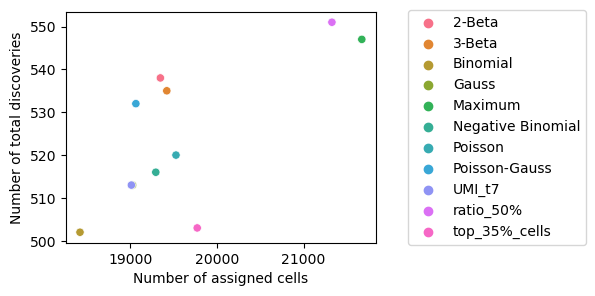

In [20]:
# plot the results
plt.figure(figsize = (4,3))
sns.scatterplot(data = discovery_analysis, x = "n_cells", y = "n_discoveries", hue = "method")
plt.ylabel('Number of total discoveries')
plt.xlabel('Number of assigned cells')
plt.legend(bbox_to_anchor=(1.7, 0.5), loc='center right')
plt.show()

**Note:** this differs from the results show in our paper as we here calculate the discoveries per perturbation, whereas in the analysis of our paper we did the differential expression test separately for each gRNA instead of combining the four gRNAs with the same target. Additionally, SCEPTRE has been used for the analysis shown in the paper with additional covariates such as total gRNA and mRNA counts per cell.